In [1]:
#from google.colab import files
#uploaded = files.upload()

In [2]:
import io
data = open('dinos.txt', 'r').read()

In [3]:
data = data.lower()
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)

In [4]:
data_size

19909

In [5]:
vocab_size

27

In [6]:
char_to_idx = {ch: i for i, ch in enumerate(sorted(chars))}
char_to_idx

{'\n': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
idx_to_char = {i: ch for i, ch in enumerate(sorted(chars))}
idx_to_char

{0: '\n',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z'}

In [8]:
data = data.split('\n')
data

['aachenosaurus',
 'aardonyx',
 'abdallahsaurus',
 'abelisaurus',
 'abrictosaurus',
 'abrosaurus',
 'abydosaurus',
 'acanthopholis',
 'achelousaurus',
 'acheroraptor',
 'achillesaurus',
 'achillobator',
 'acristavus',
 'acrocanthosaurus',
 'acrotholus',
 'actiosaurus',
 'adamantisaurus',
 'adasaurus',
 'adelolophus',
 'adeopapposaurus',
 'aegyptosaurus',
 'aeolosaurus',
 'aepisaurus',
 'aepyornithomimus',
 'aerosteon',
 'aetonyxafromimus',
 'afrovenator',
 'agathaumas',
 'aggiosaurus',
 'agilisaurus',
 'agnosphitys',
 'agrosaurus',
 'agujaceratops',
 'agustinia',
 'ahshislepelta',
 'airakoraptor',
 'ajancingenia',
 'ajkaceratops',
 'alamosaurus',
 'alaskacephale',
 'albalophosaurus',
 'albertaceratops',
 'albertadromeus',
 'albertavenator',
 'albertonykus',
 'albertosaurus',
 'albinykus',
 'albisaurus',
 'alcovasaurus',
 'alectrosaurus',
 'aletopelta',
 'algoasaurus',
 'alioramus',
 'aliwalia',
 'allosaurus',
 'almas',
 'alnashetri',
 'alocodon',
 'altirhinus',
 'altispinax',
 'alvarez

In [9]:
import torch
import torch.nn as nn

In [10]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, inputs, hidden):
    input_combined = torch.cat((inputs, hidden), 1)
    hidden = self.i2h(input_combined)
    output = self.i2o(input_combined)
    output_combined = torch.cat((hidden, output), 1)
    output = self.o2o(output_combined)
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [11]:
def inputTensor(line):
  tensor = torch.zeros(len(line), 1, vocab_size)
  for li in range(len(line)):
    letter = line[li]
    tensor[li][0][char_to_idx[letter]] = 1
  return tensor

def targetTensor(line):
  letter_indexes = [char_to_idx[line[li]] for li in range(1, len(line))]
  letter_indexes.append(0)
  return torch.LongTensor(letter_indexes)

In [12]:
import random

def randomExample(l):
  line = l[random.randint(0, len(l)-1)]
  input_line_tensor = inputTensor(line)
  target_line_tensor = targetTensor(line)
  return input_line_tensor, target_line_tensor

In [13]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor, rnn):
  target_line_tensor.unsqueeze_(-1)
  hidden = rnn.initHidden()

  rnn.zero_grad()

  loss = 0

  for i in range(input_line_tensor.size(0)):
    output, hidden = rnn(input_line_tensor[i], hidden)
    l = criterion(output, target_line_tensor[i])
    loss += l
  
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item() / input_line_tensor.size(0)

In [14]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
rnn = RNN(vocab_size, 128, vocab_size)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
  input_line_tensor, target_line_tensor = randomExample(data)
  output, loss = train(input_line_tensor, target_line_tensor, rnn)
  total_loss += loss

  if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

  if iter % plot_every == 0:
      all_losses.append(total_loss / plot_every)
      total_loss = 0

0m 21s (5000 5%) 1.2385
0m 40s (10000 10%) 2.2775
0m 59s (15000 15%) 1.3441
1m 18s (20000 20%) 2.3540
1m 37s (25000 25%) 2.3123
1m 56s (30000 30%) 2.9127
2m 15s (35000 35%) 1.1535
2m 33s (40000 40%) 0.9749
2m 52s (45000 45%) 2.1072
3m 11s (50000 50%) 1.1545
3m 30s (55000 55%) 1.1171
3m 49s (60000 60%) 1.7275
4m 8s (65000 65%) 1.0887
4m 27s (70000 70%) 1.2436
4m 45s (75000 75%) 3.1446
5m 4s (80000 80%) 1.2670
5m 23s (85000 85%) 1.1568
5m 42s (90000 90%) 1.5613
6m 1s (95000 95%) 1.2431
6m 20s (100000 100%) 1.7608


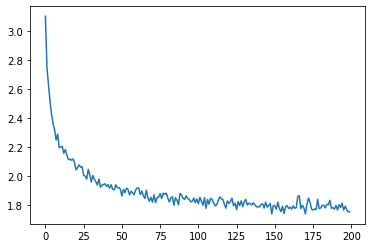

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [29]:
max_length = 20

def sample(start_letter='a'):
  with torch.no_grad():
    inp = inputTensor(start_letter)
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
      output, hidden = rnn(inp[0], hidden)
      topv, topi = output.topk(1)
      topi = topi[0][0]
      if topi == 0:
        break
      else:
        letter = idx_to_char[topi.item()]
        output_name += letter
      inp = inputTensor(letter)

    return output_name

In [30]:
sample('h')

'haliagosaurus'